In [1]:
import sys
# sys.path.insert(0, '../../Utilities/')
from mpl_toolkits import mplot3d
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# tf.enable_eager_execution()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
class PhysicsInformedNN3:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub, q):
        
        self.loss_array= []
        self.lambda_array= []
        
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        self.q = q
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([1.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = (X - self.lb)/(self.ub - self.lb) 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.math.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        q = self.q 
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
#         f= q+ lambda_1*u_x
        f = q - lambda_1*(tf.math.sqrt(tf.math.square(u_x) + tf.math.square(u_t))) 
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, lambda_2))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                
                self.loss_array.append(loss_value)
                self.lambda_array.append(lambda_1_value)
#                 lolz= self.sess.run(self.net_f(self.x_tf,self.t_tf) , tf_dict)
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
#                 print(lolz)
                start_time = time.time()
        
#         self.optimizer_Adam.minimize(self.loss)
        
        
#         self.optimizer.minimize(self.sess,
#                                 feed_dict = tf_dict,
#                                 fetches = [self.loss, self.lambda_1, self.lambda_2],
#                                 loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [4]:
df= pd.read_csv(r"C:\Users\Omkar\Downloads\K1 ND K0.5_.csv")

NameError: name 'pd' is not defined

In [3]:
q_z= df.loc[:,["Directional Heat Flux (Z)" ]] 

NameError: name 'df' is not defined

In [2]:
q_z.shape

NameError: name 'q_z' is not defined

In [5]:
q_z_new=np.array(q_z)

In [6]:
q_z_new_sq=np.square(q_z_new)

In [7]:
q_x= df.loc[:,["Directional Heat Flux (X)" ]] 

In [8]:
q_x_new=np.array(q_x)

In [9]:
q_x_new_sq=np.square(q_x_new)

In [10]:
q_final = np.sqrt((q_x_new_sq+q_z_new_sq))

In [10]:
# scaler = MinMaxScaler()
# model4 = scaler.fit(q_x_new)
# scaled_q = model4.transform(q_x_new)

In [11]:
x_y=df.loc[:,["X Location (m)","Z Location (m)" ]] 

In [12]:
x_y=np.array(x_y)

In [13]:
u=df.loc[:,"Temperature (°C)"]

In [14]:
u=np.array(u)

In [15]:
u=u.reshape(160801,1)

In [16]:
N_u_1=3000
layers1 = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [17]:
lb1 = x_y.min(0)
ub1 = x_y.max(0)

In [18]:
idx = np.random.choice(x_y.shape[0], N_u_1, replace=False)
X_u_train = x_y[idx,:]
u_train = u[idx,:]
# q = scaled_q[idx,:]
q_= q_final[idx,:]
q_t= tf.convert_to_tensor(q_,dtype=tf.float32)
# q_= tf.convert_to_tensor(q,dtype=tf.float32)


In [23]:
model = PhysicsInformedNN3(X_u_train, u_train, layers1, lb1, ub1 , q_t)
model.train(50000)

Device mapping:

It: 0, Loss: 5.603e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.57
It: 10, Loss: 5.118e-01, Lambda_1: 0.009, Lambda_2: 1.000000, Time: 0.14
It: 20, Loss: 5.149e-01, Lambda_1: 0.018, Lambda_2: 1.000000, Time: 0.13
It: 30, Loss: 5.116e-01, Lambda_1: 0.027, Lambda_2: 1.000000, Time: 0.14
It: 40, Loss: 5.116e-01, Lambda_1: 0.035, Lambda_2: 1.000000, Time: 0.19
It: 50, Loss: 5.114e-01, Lambda_1: 0.043, Lambda_2: 1.000000, Time: 0.19
It: 60, Loss: 5.113e-01, Lambda_1: 0.050, Lambda_2: 1.000000, Time: 0.11
It: 70, Loss: 5.113e-01, Lambda_1: 0.056, Lambda_2: 1.000000, Time: 0.12
It: 80, Loss: 5.113e-01, Lambda_1: 0.062, Lambda_2: 1.000000, Time: 0.12
It: 90, Loss: 5.113e-01, Lambda_1: 0.068, Lambda_2: 1.000000, Time: 0.12
It: 100, Loss: 5.113e-01, Lambda_1: 0.075, Lambda_2: 1.000000, Time: 0.09
It: 110, Loss: 5.113e-01, Lambda_1: 0.082, Lambda_2: 1.000000, Time: 0.10
It: 120, Loss: 5.113e-01, Lambda_1: 0.091, Lambda_2: 1.000000, Time: 0.14
It: 130, Loss: 5.113e-01, Lambda

It: 1120, Loss: 1.463e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 1130, Loss: 1.463e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 1140, Loss: 1.463e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 1150, Loss: 1.463e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 1160, Loss: 1.462e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 1170, Loss: 1.462e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 1180, Loss: 1.462e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.14
It: 1190, Loss: 1.462e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.11
It: 1200, Loss: 1.462e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.17
It: 1210, Loss: 1.462e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.13
It: 1220, Loss: 1.462e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.20
It: 1230, Loss: 1.462e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.12
It: 1240, Loss: 1.462e-01, Lambda_1: 0.866, Lambda_2: 1.000000, Time: 0.14
It: 1250, Loss: 1.461e-01

It: 2230, Loss: 1.359e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 2240, Loss: 1.358e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 2250, Loss: 1.358e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 2260, Loss: 1.358e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.23
It: 2270, Loss: 1.358e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.19
It: 2280, Loss: 1.358e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.13
It: 2290, Loss: 1.357e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.12
It: 2300, Loss: 1.357e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.12
It: 2310, Loss: 1.357e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.12
It: 2320, Loss: 1.357e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 2330, Loss: 1.357e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 2340, Loss: 1.357e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.11
It: 2350, Loss: 1.357e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.12
It: 2360, Loss: 1.356e-01

It: 3340, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 3350, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.13
It: 3360, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.19
It: 3370, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.19
It: 3380, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.16
It: 3390, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.23
It: 3400, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.28
It: 3410, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.27
It: 3420, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.22
It: 3430, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.13
It: 3440, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 3450, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 3460, Loss: 1.351e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.14
It: 3470, Loss: 1.351e-01

It: 4450, Loss: 1.351e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.13
It: 4460, Loss: 1.351e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.13
It: 4470, Loss: 1.351e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.12
It: 4480, Loss: 1.351e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.12
It: 4490, Loss: 1.351e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.12
It: 4500, Loss: 1.351e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.13
It: 4510, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 4520, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.14
It: 4530, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.19
It: 4540, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.26
It: 4550, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.16
It: 4560, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.19
It: 4570, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.14
It: 4580, Loss: 1.350e-01

It: 5550, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.20
It: 5560, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.28
It: 5570, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.19
It: 5580, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.20
It: 5590, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.20
It: 5600, Loss: 1.350e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.22
It: 5610, Loss: 1.349e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.20
It: 5620, Loss: 1.349e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.23
It: 5630, Loss: 1.349e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.24
It: 5640, Loss: 1.349e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.21
It: 5650, Loss: 1.349e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.19
It: 5660, Loss: 1.349e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.20
It: 5670, Loss: 1.349e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.20
It: 5680, Loss: 1.349e-01

It: 6650, Loss: 1.090e-01, Lambda_1: 0.731, Lambda_2: 1.000000, Time: 0.22
It: 6660, Loss: 1.087e-01, Lambda_1: 0.731, Lambda_2: 1.000000, Time: 0.19
It: 6670, Loss: 1.085e-01, Lambda_1: 0.730, Lambda_2: 1.000000, Time: 0.18
It: 6680, Loss: 1.083e-01, Lambda_1: 0.729, Lambda_2: 1.000000, Time: 0.17
It: 6690, Loss: 1.081e-01, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.17
It: 6700, Loss: 1.082e-01, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.19
It: 6710, Loss: 1.078e-01, Lambda_1: 0.728, Lambda_2: 1.000000, Time: 0.26
It: 6720, Loss: 1.076e-01, Lambda_1: 0.727, Lambda_2: 1.000000, Time: 0.24
It: 6730, Loss: 1.075e-01, Lambda_1: 0.727, Lambda_2: 1.000000, Time: 0.19
It: 6740, Loss: 1.073e-01, Lambda_1: 0.726, Lambda_2: 1.000000, Time: 0.20
It: 6750, Loss: 1.072e-01, Lambda_1: 0.726, Lambda_2: 1.000000, Time: 0.24
It: 6760, Loss: 1.071e-01, Lambda_1: 0.725, Lambda_2: 1.000000, Time: 0.17
It: 6770, Loss: 1.070e-01, Lambda_1: 0.725, Lambda_2: 1.000000, Time: 0.22
It: 6780, Loss: 1.069e-01

It: 7750, Loss: 1.040e-01, Lambda_1: 0.701, Lambda_2: 1.000000, Time: 0.23
It: 7760, Loss: 1.040e-01, Lambda_1: 0.701, Lambda_2: 1.000000, Time: 0.23
It: 7770, Loss: 1.049e-01, Lambda_1: 0.701, Lambda_2: 1.000000, Time: 0.18
It: 7780, Loss: 1.040e-01, Lambda_1: 0.701, Lambda_2: 1.000000, Time: 0.18
It: 7790, Loss: 1.040e-01, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.22
It: 7800, Loss: 1.039e-01, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.17
It: 7810, Loss: 1.038e-01, Lambda_1: 0.699, Lambda_2: 1.000000, Time: 0.19
It: 7820, Loss: 1.038e-01, Lambda_1: 0.699, Lambda_2: 1.000000, Time: 0.26
It: 7830, Loss: 1.038e-01, Lambda_1: 0.699, Lambda_2: 1.000000, Time: 0.26
It: 7840, Loss: 1.037e-01, Lambda_1: 0.699, Lambda_2: 1.000000, Time: 0.24
It: 7850, Loss: 1.037e-01, Lambda_1: 0.698, Lambda_2: 1.000000, Time: 0.16
It: 7860, Loss: 1.037e-01, Lambda_1: 0.698, Lambda_2: 1.000000, Time: 0.28
It: 7870, Loss: 1.036e-01, Lambda_1: 0.698, Lambda_2: 1.000000, Time: 0.28
It: 7880, Loss: 1.036e-01

It: 8850, Loss: 6.516e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.21
It: 8860, Loss: 6.505e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.17
It: 8870, Loss: 6.494e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.22
It: 8880, Loss: 6.482e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.27
It: 8890, Loss: 6.470e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.16
It: 8900, Loss: 6.458e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.17
It: 8910, Loss: 6.446e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.17
It: 8920, Loss: 6.434e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.18
It: 8930, Loss: 6.421e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.19
It: 8940, Loss: 6.408e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.23
It: 8950, Loss: 6.395e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.24
It: 8960, Loss: 6.382e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.18
It: 8970, Loss: 6.368e-02, Lambda_1: 0.722, Lambda_2: 1.000000, Time: 0.22
It: 8980, Loss: 6.353e-02

It: 9950, Loss: 2.670e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.24
It: 9960, Loss: 2.652e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.19
It: 9970, Loss: 2.635e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.18
It: 9980, Loss: 2.618e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.26
It: 9990, Loss: 2.601e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.19
It: 10000, Loss: 2.584e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.20
It: 10010, Loss: 2.568e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.26
It: 10020, Loss: 2.597e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.17
It: 10030, Loss: 2.627e-02, Lambda_1: 0.737, Lambda_2: 1.000000, Time: 0.17
It: 10040, Loss: 2.549e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.19
It: 10050, Loss: 2.516e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.20
It: 10060, Loss: 2.495e-02, Lambda_1: 0.738, Lambda_2: 1.000000, Time: 0.19
It: 10070, Loss: 2.480e-02, Lambda_1: 0.737, Lambda_2: 1.000000, Time: 0.24
It: 10080, Loss: 

It: 11030, Loss: 1.715e-02, Lambda_1: 0.725, Lambda_2: 1.000000, Time: 0.17
It: 11040, Loss: 1.706e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.25
It: 11050, Loss: 1.698e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.16
It: 11060, Loss: 1.693e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.19
It: 11070, Loss: 1.687e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.24
It: 11080, Loss: 1.682e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.26
It: 11090, Loss: 1.711e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.28
It: 11100, Loss: 1.672e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.28
It: 11110, Loss: 1.674e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.25
It: 11120, Loss: 1.668e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.15
It: 11130, Loss: 1.658e-02, Lambda_1: 0.724, Lambda_2: 1.000000, Time: 0.17
It: 11140, Loss: 1.651e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.17
It: 11150, Loss: 1.645e-02, Lambda_1: 0.723, Lambda_2: 1.000000, Time: 0.19
It: 11160, L

It: 12120, Loss: 1.264e-02, Lambda_1: 0.719, Lambda_2: 1.000000, Time: 0.23
It: 12130, Loss: 1.257e-02, Lambda_1: 0.719, Lambda_2: 1.000000, Time: 0.27
It: 12140, Loss: 1.254e-02, Lambda_1: 0.719, Lambda_2: 1.000000, Time: 0.20
It: 12150, Loss: 1.250e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.25
It: 12160, Loss: 1.249e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.15
It: 12170, Loss: 1.265e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.17
It: 12180, Loss: 1.257e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.17
It: 12190, Loss: 1.254e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.18
It: 12200, Loss: 1.238e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.21
It: 12210, Loss: 1.235e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.22
It: 12220, Loss: 1.230e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.25
It: 12230, Loss: 1.228e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.23
It: 12240, Loss: 1.255e-02, Lambda_1: 0.718, Lambda_2: 1.000000, Time: 0.18
It: 12250, L

It: 13210, Loss: 1.086e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.19
It: 13220, Loss: 1.080e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.17
It: 13230, Loss: 1.079e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.19
It: 13240, Loss: 1.080e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.22
It: 13250, Loss: 1.153e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.24
It: 13260, Loss: 1.084e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.18
It: 13270, Loss: 1.076e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.24
It: 13280, Loss: 1.079e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.25
It: 13290, Loss: 1.079e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.16
It: 13300, Loss: 1.076e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.19
It: 13310, Loss: 1.075e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.22
It: 13320, Loss: 1.089e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.17
It: 13330, Loss: 1.098e-02, Lambda_1: 0.714, Lambda_2: 1.000000, Time: 0.17
It: 13340, L

It: 14290, Loss: 1.039e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.40
It: 14300, Loss: 1.032e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.40
It: 14310, Loss: 1.034e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.38
It: 14320, Loss: 1.052e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.36
It: 14330, Loss: 1.030e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.41
It: 14340, Loss: 1.024e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.36
It: 14350, Loss: 1.033e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.36
It: 14360, Loss: 1.061e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.37
It: 14370, Loss: 1.024e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.43
It: 14380, Loss: 1.035e-02, Lambda_1: 0.710, Lambda_2: 1.000000, Time: 0.40
It: 14390, Loss: 1.023e-02, Lambda_1: 0.709, Lambda_2: 1.000000, Time: 0.34
It: 14400, Loss: 1.022e-02, Lambda_1: 0.709, Lambda_2: 1.000000, Time: 0.40
It: 14410, Loss: 1.025e-02, Lambda_1: 0.709, Lambda_2: 1.000000, Time: 0.32
It: 14420, L

It: 15370, Loss: 9.889e-03, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.27
It: 15380, Loss: 9.938e-03, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.26
It: 15390, Loss: 1.026e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.27
It: 15400, Loss: 9.919e-03, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.28
It: 15410, Loss: 9.951e-03, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.27
It: 15420, Loss: 1.001e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.27
It: 15430, Loss: 9.948e-03, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.27
It: 15440, Loss: 9.935e-03, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.27
It: 15450, Loss: 1.005e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.28
It: 15460, Loss: 1.001e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.30
It: 15470, Loss: 9.863e-03, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.27
It: 15480, Loss: 9.866e-03, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.27
It: 15490, Loss: 1.007e-02, Lambda_1: 0.706, Lambda_2: 1.000000, Time: 0.29
It: 15500, L

It: 16450, Loss: 9.729e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.27
It: 16460, Loss: 9.653e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.19
It: 16470, Loss: 9.687e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.23
It: 16480, Loss: 9.916e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.24
It: 16490, Loss: 9.635e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.24
It: 16500, Loss: 9.603e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.24
It: 16510, Loss: 9.745e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.18
It: 16520, Loss: 9.842e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.18
It: 16530, Loss: 9.600e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.19
It: 16540, Loss: 9.730e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.20
It: 16550, Loss: 9.694e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.20
It: 16560, Loss: 9.636e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.21
It: 16570, Loss: 9.691e-03, Lambda_1: 0.703, Lambda_2: 1.000000, Time: 0.19
It: 16580, L

It: 17530, Loss: 9.411e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.19
It: 17540, Loss: 9.448e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.20
It: 17550, Loss: 9.478e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.18
It: 17560, Loss: 9.410e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.20
It: 17570, Loss: 9.431e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.21
It: 17580, Loss: 9.608e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.23
It: 17590, Loss: 9.415e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.24
It: 17600, Loss: 9.350e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.27
It: 17610, Loss: 9.443e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.18
It: 17620, Loss: 9.844e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.20
It: 17630, Loss: 9.348e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.26
It: 17640, Loss: 9.475e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.17
It: 17650, Loss: 9.386e-03, Lambda_1: 0.700, Lambda_2: 1.000000, Time: 0.17
It: 17660, L

It: 18610, Loss: 9.165e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.17
It: 18620, Loss: 9.211e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.23
It: 18630, Loss: 9.314e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.17
It: 18640, Loss: 9.217e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.20
It: 18650, Loss: 9.160e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.26
It: 18660, Loss: 9.229e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.26
It: 18670, Loss: 9.500e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.16
It: 18680, Loss: 9.123e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.17
It: 18690, Loss: 9.257e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.26
It: 18700, Loss: 9.259e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.17
It: 18710, Loss: 9.172e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.19
It: 18720, Loss: 9.197e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.20
It: 18730, Loss: 9.440e-03, Lambda_1: 0.697, Lambda_2: 1.000000, Time: 0.18
It: 18740, L

It: 19690, Loss: 9.060e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.24
It: 19700, Loss: 8.986e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.17
It: 19710, Loss: 8.898e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.19
It: 19720, Loss: 8.909e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.20
It: 19730, Loss: 9.193e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.18
It: 19740, Loss: 8.935e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.20
It: 19750, Loss: 9.005e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.24
It: 19760, Loss: 8.939e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.19
It: 19770, Loss: 8.873e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.24
It: 19780, Loss: 8.869e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.26
It: 19790, Loss: 8.890e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.19
It: 19800, Loss: 9.774e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.19
It: 19810, Loss: 8.937e-03, Lambda_1: 0.695, Lambda_2: 1.000000, Time: 0.17
It: 19820, L

It: 20780, Loss: 8.873e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.21
It: 20790, Loss: 9.056e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.21
It: 20800, Loss: 8.775e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.22
It: 20810, Loss: 8.796e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.25
It: 20820, Loss: 8.708e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.22
It: 20830, Loss: 8.712e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.17
It: 20840, Loss: 8.849e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.19
It: 20850, Loss: 9.109e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.19
It: 20860, Loss: 8.811e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.19
It: 20870, Loss: 8.745e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.19
It: 20880, Loss: 8.714e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.19
It: 20890, Loss: 8.799e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.23
It: 20900, Loss: 8.960e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.27
It: 20910, L

It: 21860, Loss: 8.629e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.20
It: 21870, Loss: 8.637e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.19
It: 21880, Loss: 8.718e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.19
It: 21890, Loss: 8.646e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.20
It: 21900, Loss: 8.567e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.20
It: 21910, Loss: 8.582e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.19
It: 21920, Loss: 8.874e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.20
It: 21930, Loss: 8.579e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.27
It: 21940, Loss: 8.677e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.27
It: 21950, Loss: 8.599e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.23
It: 21960, Loss: 8.542e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.18
It: 21970, Loss: 8.539e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.19
It: 21980, Loss: 8.543e-03, Lambda_1: 0.694, Lambda_2: 1.000000, Time: 0.17
It: 21990, L

It: 22940, Loss: 8.503e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.20
It: 22950, Loss: 8.489e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.26
It: 22960, Loss: 8.412e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.23
It: 22970, Loss: 8.426e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.19
It: 22980, Loss: 8.761e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.24
It: 22990, Loss: 8.427e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.18
It: 23000, Loss: 8.496e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.19
It: 23010, Loss: 8.447e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.21
It: 23020, Loss: 8.388e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.18
It: 23030, Loss: 8.387e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.20
It: 23040, Loss: 8.507e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.29
It: 23050, Loss: 8.707e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.27
It: 23060, Loss: 8.602e-03, Lambda_1: 0.693, Lambda_2: 1.000000, Time: 0.23
It: 23070, L

It: 24030, Loss: 8.384e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.19
It: 24040, Loss: 8.343e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.19
It: 24050, Loss: 8.241e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.20
It: 24060, Loss: 8.242e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.19
It: 24070, Loss: 8.496e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.24
It: 24080, Loss: 8.337e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.17
It: 24090, Loss: 8.367e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.25
It: 24100, Loss: 8.229e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.26
It: 24110, Loss: 8.240e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.24
It: 24120, Loss: 8.360e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.16
It: 24130, Loss: 8.435e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.17
It: 24140, Loss: 8.212e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.19
It: 24150, Loss: 8.251e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.19
It: 24160, L

It: 25110, Loss: 8.135e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.25
It: 25120, Loss: 8.484e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.16
It: 25130, Loss: 8.058e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.24
It: 25140, Loss: 8.175e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.26
It: 25150, Loss: 8.108e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.20
It: 25160, Loss: 8.070e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.16
It: 25170, Loss: 8.129e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.19
It: 25180, Loss: 8.423e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.19
It: 25190, Loss: 8.057e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.17
It: 25200, Loss: 8.181e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.20
It: 25210, Loss: 8.068e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.27
It: 25220, Loss: 8.046e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.19
It: 25230, Loss: 8.058e-03, Lambda_1: 0.692, Lambda_2: 1.000000, Time: 0.18
It: 25240, L

It: 26190, Loss: 7.915e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.26
It: 26200, Loss: 7.906e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.17
It: 26210, Loss: 7.897e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.20
It: 26220, Loss: 7.910e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.27
It: 26230, Loss: 8.258e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.27
It: 26240, Loss: 7.895e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.27
It: 26250, Loss: 8.014e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.22
It: 26260, Loss: 7.918e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.17
It: 26270, Loss: 7.939e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.17
It: 26280, Loss: 7.916e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.17
It: 26290, Loss: 7.974e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.18
It: 26300, Loss: 8.160e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.25
It: 26310, Loss: 7.880e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.25
It: 26320, L

It: 27270, Loss: 7.759e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.25
It: 27280, Loss: 7.798e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.25
It: 27290, Loss: 7.926e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.23
It: 27300, Loss: 7.826e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.23
It: 27310, Loss: 7.747e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.20
It: 27320, Loss: 7.798e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.20
It: 27330, Loss: 8.195e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.24
It: 27340, Loss: 7.744e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.25
It: 27350, Loss: 7.840e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.19
It: 27360, Loss: 7.745e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.19
It: 27370, Loss: 7.742e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.17
It: 27380, Loss: 7.806e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.19
It: 27390, Loss: 8.349e-03, Lambda_1: 0.691, Lambda_2: 1.000000, Time: 0.20
It: 27400, L

It: 28350, Loss: 7.734e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.19
It: 28360, Loss: 7.926e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.19
It: 28370, Loss: 7.630e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.21
It: 28380, Loss: 7.709e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.26
It: 28390, Loss: 7.702e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.19
It: 28400, Loss: 7.678e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.22
It: 28410, Loss: 7.710e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.28
It: 28420, Loss: 7.801e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.27
It: 28430, Loss: 7.655e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.23
It: 28440, Loss: 7.623e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.17
It: 28450, Loss: 7.681e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.17
It: 28460, Loss: 8.118e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.18
It: 28470, Loss: 7.643e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.20
It: 28480, L

It: 29430, Loss: 7.603e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.22
It: 29440, Loss: 8.014e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.18
It: 29450, Loss: 7.590e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.20
It: 29460, Loss: 7.534e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.20
It: 29470, Loss: 7.562e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.21
It: 29480, Loss: 7.564e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.27
It: 29490, Loss: 7.584e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.17
It: 29500, Loss: 7.701e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.21
It: 29510, Loss: 7.597e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.29
It: 29520, Loss: 7.521e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.27
It: 29530, Loss: 7.570e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.26
It: 29540, Loss: 7.793e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.16
It: 29550, Loss: 7.521e-03, Lambda_1: 0.690, Lambda_2: 1.000000, Time: 0.17
It: 29560, L

It: 30510, Loss: 7.601e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.19
It: 30520, Loss: 7.466e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.24
It: 30530, Loss: 7.436e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.17
It: 30540, Loss: 7.480e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.20
It: 30550, Loss: 7.735e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.27
It: 30560, Loss: 7.431e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.19
It: 30570, Loss: 7.495e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.19
It: 30580, Loss: 7.429e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.19
It: 30590, Loss: 7.451e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.20
It: 30600, Loss: 7.565e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.19
It: 30610, Loss: 7.560e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.21
It: 30620, Loss: 7.449e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.26
It: 30630, Loss: 7.482e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.24
It: 30640, L

It: 31590, Loss: 7.353e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.22
It: 31600, Loss: 7.340e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.21
It: 31610, Loss: 7.346e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.19
It: 31620, Loss: 7.340e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.25
It: 31630, Loss: 7.338e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.28
It: 31640, Loss: 7.347e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.25
It: 31650, Loss: 7.559e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.17
It: 31660, Loss: 7.371e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.19
It: 31670, Loss: 7.396e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.17
It: 31680, Loss: 7.378e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.20
It: 31690, Loss: 7.336e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.19
It: 31700, Loss: 7.343e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.20
It: 31710, Loss: 7.332e-03, Lambda_1: 0.689, Lambda_2: 1.000000, Time: 0.22
It: 31720, L

It: 32680, Loss: 7.244e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.18
It: 32690, Loss: 7.263e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.22
It: 32700, Loss: 7.356e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.19
It: 32710, Loss: 7.345e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.22
It: 32720, Loss: 7.260e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.28
It: 32730, Loss: 7.271e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.19
It: 32740, Loss: 7.243e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.18
It: 32750, Loss: 7.242e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.26
It: 32760, Loss: 7.304e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.18
It: 32770, Loss: 7.610e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.20
It: 32780, Loss: 7.309e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.18
It: 32790, Loss: 7.233e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.20
It: 32800, Loss: 7.250e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.23
It: 32810, L

It: 33760, Loss: 7.288e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.23
It: 33770, Loss: 7.194e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.17
It: 33780, Loss: 7.163e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.19
It: 33790, Loss: 7.198e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.19
It: 33800, Loss: 7.276e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.20
It: 33810, Loss: 7.186e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.20
It: 33820, Loss: 7.163e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.23
It: 33830, Loss: 7.201e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.23
It: 33840, Loss: 7.274e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.25
It: 33850, Loss: 7.184e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.19
It: 33860, Loss: 7.154e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.19
It: 33870, Loss: 7.188e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.22
It: 33880, Loss: 7.307e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.21
It: 33890, L

It: 34850, Loss: 7.090e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 34860, Loss: 7.089e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.27
It: 34870, Loss: 7.089e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.25
It: 34880, Loss: 7.090e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.16
It: 34890, Loss: 7.122e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.17
It: 34900, Loss: 7.505e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.17
It: 34910, Loss: 7.202e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.19
It: 34920, Loss: 7.116e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.19
It: 34930, Loss: 7.086e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.21
It: 34940, Loss: 7.091e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.22
It: 34950, Loss: 7.087e-03, Lambda_1: 0.688, Lambda_2: 1.000000, Time: 0.21
It: 34960, Loss: 7.088e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 34970, Loss: 7.091e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 34980, L

It: 35930, Loss: 7.048e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 35940, Loss: 7.038e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 35950, Loss: 7.047e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 35960, Loss: 7.078e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 35970, Loss: 7.240e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 35980, Loss: 7.036e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.17
It: 35990, Loss: 7.076e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 36000, Loss: 7.035e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.26
It: 36010, Loss: 7.033e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 36020, Loss: 7.053e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 36030, Loss: 7.361e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 36040, Loss: 7.035e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 36050, Loss: 7.034e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 36060, L

It: 37010, Loss: 7.013e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 37020, Loss: 6.989e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 37030, Loss: 6.998e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 37040, Loss: 6.996e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 37050, Loss: 7.006e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.25
It: 37060, Loss: 7.134e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 37070, Loss: 7.055e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 37080, Loss: 7.055e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 37090, Loss: 6.989e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 37100, Loss: 7.004e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 37110, Loss: 6.996e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 37120, Loss: 7.009e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 37130, Loss: 7.156e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 37140, L

It: 38090, Loss: 6.994e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 38100, Loss: 6.968e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.17
It: 38110, Loss: 6.963e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 38120, Loss: 6.953e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 38130, Loss: 6.946e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.17
It: 38140, Loss: 6.947e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 38150, Loss: 6.951e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 38160, Loss: 7.002e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 38170, Loss: 7.249e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 38180, Loss: 7.026e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.27
It: 38190, Loss: 6.950e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 38200, Loss: 6.952e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 38210, Loss: 6.949e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 38220, L

It: 39170, Loss: 6.925e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 39180, Loss: 6.913e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.26
It: 39190, Loss: 6.909e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 39200, Loss: 6.909e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 39210, Loss: 6.908e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.25
It: 39220, Loss: 6.909e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 39230, Loss: 6.912e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 39240, Loss: 6.988e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 39250, Loss: 7.205e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 39260, Loss: 7.032e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 39270, Loss: 6.956e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.27
It: 39280, Loss: 6.926e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 39290, Loss: 6.906e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.18
It: 39300, L

It: 40250, Loss: 6.882e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 40260, Loss: 7.248e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 40270, Loss: 6.913e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 40280, Loss: 6.939e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 40290, Loss: 6.909e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.23
It: 40300, Loss: 6.887e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 40310, Loss: 6.875e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 40320, Loss: 6.871e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 40330, Loss: 6.872e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 40340, Loss: 6.870e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.22
It: 40350, Loss: 6.870e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.24
It: 40360, Loss: 6.870e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.19
It: 40370, Loss: 6.902e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.21
It: 40380, L

It: 41330, Loss: 6.902e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 41340, Loss: 6.885e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 41350, Loss: 6.857e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 41360, Loss: 6.865e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 41370, Loss: 6.996e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 41380, Loss: 6.877e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.20
It: 41390, Loss: 6.892e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 41400, Loss: 6.834e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.25
It: 41410, Loss: 6.852e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 41420, Loss: 6.885e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 41430, Loss: 6.967e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 41440, Loss: 6.846e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 41450, Loss: 6.855e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 41460, L

It: 42410, Loss: 6.800e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.26
It: 42420, Loss: 6.808e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.26
It: 42430, Loss: 7.205e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.26
It: 42440, Loss: 6.934e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.26
It: 42450, Loss: 6.916e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.27
It: 42460, Loss: 6.828e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.26
It: 42470, Loss: 6.802e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.27
It: 42480, Loss: 6.799e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.26
It: 42490, Loss: 6.799e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.26
It: 42500, Loss: 6.798e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.24
It: 42510, Loss: 6.797e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.24
It: 42520, Loss: 6.797e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.24
It: 42530, Loss: 6.797e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.24
It: 42540, L

It: 43490, Loss: 6.765e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 43500, Loss: 6.764e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.23
It: 43510, Loss: 6.764e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.23
It: 43520, Loss: 6.764e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 43530, Loss: 6.763e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 43540, Loss: 6.763e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 43550, Loss: 6.762e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 43560, Loss: 6.766e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.23
It: 43570, Loss: 6.961e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.23
It: 43580, Loss: 6.791e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 43590, Loss: 6.777e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 43600, Loss: 6.796e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 43610, Loss: 6.781e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 43620, L

It: 44580, Loss: 6.775e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 44590, Loss: 6.784e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 44600, Loss: 6.759e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 44610, Loss: 6.728e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 44620, Loss: 6.737e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 44630, Loss: 6.746e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.27
It: 44640, Loss: 6.826e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 44650, Loss: 6.900e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.23
It: 44660, Loss: 6.778e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.16
It: 44670, Loss: 6.728e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 44680, Loss: 6.744e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 44690, Loss: 6.746e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 44700, Loss: 6.773e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 44710, L

It: 45660, Loss: 6.696e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 45670, Loss: 6.695e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.24
It: 45680, Loss: 6.695e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 45690, Loss: 6.702e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 45700, Loss: 7.100e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 45710, Loss: 6.835e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 45720, Loss: 6.820e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.24
It: 45730, Loss: 6.705e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.25
It: 45740, Loss: 6.695e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 45750, Loss: 6.696e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 45760, Loss: 6.694e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 45770, Loss: 6.692e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 45780, Loss: 6.692e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 45790, L

It: 46740, Loss: 6.721e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.23
It: 46750, Loss: 6.666e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 46760, Loss: 6.674e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 46770, Loss: 6.669e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 46780, Loss: 6.665e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.22
It: 46790, Loss: 6.663e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.23
It: 46800, Loss: 6.661e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.23
It: 46810, Loss: 6.661e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.25
It: 46820, Loss: 6.661e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 46830, Loss: 6.660e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.20
It: 46840, Loss: 6.662e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.20
It: 46850, Loss: 6.786e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.26
It: 46860, Loss: 6.795e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 46870, L

It: 47820, Loss: 6.653e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 47830, Loss: 6.656e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 47840, Loss: 6.640e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.18
It: 47850, Loss: 6.634e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.24
It: 47860, Loss: 6.632e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 47870, Loss: 6.630e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.21
It: 47880, Loss: 6.630e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.27
It: 47890, Loss: 6.629e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.23
It: 47900, Loss: 6.629e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.15
It: 47910, Loss: 6.628e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.20
It: 47920, Loss: 6.634e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.22
It: 47930, Loss: 7.345e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.17
It: 47940, Loss: 7.207e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 47950, L

It: 48900, Loss: 6.599e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.19
It: 48910, Loss: 6.599e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.23
It: 48920, Loss: 6.599e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.24
It: 48930, Loss: 6.598e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.19
It: 48940, Loss: 6.603e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.22
It: 48950, Loss: 7.209e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.26
It: 48960, Loss: 6.969e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 48970, Loss: 6.618e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 48980, Loss: 6.661e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 48990, Loss: 6.598e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.21
It: 49000, Loss: 6.605e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.24
It: 49010, Loss: 6.597e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 49020, Loss: 6.596e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.23
It: 49030, L

It: 49980, Loss: 6.567e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.18
It: 49990, Loss: 6.566e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.19


In [55]:
model = PhysicsInformedNN3(X_u_train, u_train, layers1, lb1, ub1 , q_t)
model.train(10000)

Device mapping:

It: 0, Loss: 5.748e-01, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 1.08
It: 10, Loss: 5.642e-01, Lambda_1: 1.010, Lambda_2: 1.000000, Time: 0.55
It: 20, Loss: 5.611e-01, Lambda_1: 1.019, Lambda_2: 1.000000, Time: 0.49
It: 30, Loss: 5.611e-01, Lambda_1: 1.030, Lambda_2: 1.000000, Time: 0.62
It: 40, Loss: 5.611e-01, Lambda_1: 1.042, Lambda_2: 1.000000, Time: 0.55
It: 50, Loss: 5.611e-01, Lambda_1: 1.055, Lambda_2: 1.000000, Time: 0.40
It: 60, Loss: 5.610e-01, Lambda_1: 1.069, Lambda_2: 1.000000, Time: 0.39
It: 70, Loss: 5.610e-01, Lambda_1: 1.083, Lambda_2: 1.000000, Time: 0.42
It: 80, Loss: 5.610e-01, Lambda_1: 1.099, Lambda_2: 1.000000, Time: 0.41
It: 90, Loss: 5.610e-01, Lambda_1: 1.116, Lambda_2: 1.000000, Time: 0.43
It: 100, Loss: 5.610e-01, Lambda_1: 1.134, Lambda_2: 1.000000, Time: 0.42
It: 110, Loss: 5.610e-01, Lambda_1: 1.153, Lambda_2: 1.000000, Time: 0.46
It: 120, Loss: 5.610e-01, Lambda_1: 1.173, Lambda_2: 1.000000, Time: 0.43
It: 130, Loss: 5.609e-01, Lambda

It: 1110, Loss: 2.033e-01, Lambda_1: 0.864, Lambda_2: 1.000000, Time: 0.44
It: 1120, Loss: 2.033e-01, Lambda_1: 0.863, Lambda_2: 1.000000, Time: 0.60
It: 1130, Loss: 2.032e-01, Lambda_1: 0.862, Lambda_2: 1.000000, Time: 0.71
It: 1140, Loss: 2.032e-01, Lambda_1: 0.861, Lambda_2: 1.000000, Time: 0.65
It: 1150, Loss: 2.032e-01, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.67
It: 1160, Loss: 2.032e-01, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.76
It: 1170, Loss: 2.032e-01, Lambda_1: 0.859, Lambda_2: 1.000000, Time: 0.66
It: 1180, Loss: 2.032e-01, Lambda_1: 0.859, Lambda_2: 1.000000, Time: 0.60
It: 1190, Loss: 2.032e-01, Lambda_1: 0.858, Lambda_2: 1.000000, Time: 0.43
It: 1200, Loss: 2.032e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.42
It: 1210, Loss: 2.032e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.42
It: 1220, Loss: 2.032e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.45
It: 1230, Loss: 2.032e-01, Lambda_1: 0.856, Lambda_2: 1.000000, Time: 0.47
It: 1240, Loss: 2.032e-01

It: 2210, Loss: 1.924e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.60
It: 2220, Loss: 1.923e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.61
It: 2230, Loss: 1.923e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.59
It: 2240, Loss: 1.922e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.65
It: 2250, Loss: 1.922e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.56
It: 2260, Loss: 1.922e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.87
It: 2270, Loss: 1.922e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.73
It: 2280, Loss: 1.921e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.73
It: 2290, Loss: 1.921e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.63
It: 2300, Loss: 1.921e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.67
It: 2310, Loss: 1.920e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.67
It: 2320, Loss: 1.920e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.67
It: 2330, Loss: 1.920e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.56
It: 2340, Loss: 1.919e-01

It: 3310, Loss: 1.883e-01, Lambda_1: 0.856, Lambda_2: 1.000000, Time: 0.67
It: 3320, Loss: 1.883e-01, Lambda_1: 0.856, Lambda_2: 1.000000, Time: 0.45
It: 3330, Loss: 1.884e-01, Lambda_1: 0.856, Lambda_2: 1.000000, Time: 0.62
It: 3340, Loss: 1.882e-01, Lambda_1: 0.856, Lambda_2: 1.000000, Time: 0.56
It: 3350, Loss: 1.882e-01, Lambda_1: 0.856, Lambda_2: 1.000000, Time: 0.54
It: 3360, Loss: 1.881e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.64
It: 3370, Loss: 1.880e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.62
It: 3380, Loss: 1.880e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.72
It: 3390, Loss: 1.880e-01, Lambda_1: 0.857, Lambda_2: 1.000000, Time: 0.63


KeyboardInterrupt: 

In [23]:
model.loss_array

[0.6545511,
 0.48323464,
 0.44594708,
 0.4516945,
 0.4475072,
 0.44597495,
 0.4462453,
 0.44591397,
 0.44593218,
 0.4459055,
 0.4458995,
 0.44589645,
 0.445893,
 0.44588995,
 0.4458859,
 0.44588083,
 0.445874,
 0.4458645,
 0.44585148,
 0.44583243,
 0.44580448,
 0.44576168,
 0.44569466,
 0.4455851,
 0.4453985,
 0.4450658,
 0.44443774,
 0.44317228,
 0.44043088,
 0.43402767,
 0.41810402,
 0.37835968,
 0.29298857,
 0.19517478,
 0.172762,
 0.14874594,
 0.1407803,
 0.13556293,
 0.13229549,
 0.13016082,
 0.12852408,
 0.12732646,
 0.12640873,
 0.12565105,
 0.12498596,
 0.12436986,
 0.12377957,
 0.123203486,
 0.12263611,
 0.12207496,
 0.121518895,
 0.12096731,
 0.12041994,
 0.11987649,
 0.11933698,
 0.11880122,
 0.118269265,
 0.1177411,
 0.11721678,
 0.11669639,
 0.11618008,
 0.11566798,
 0.11516021,
 0.11465705,
 0.11415863,
 0.1136653,
 0.1131772,
 0.11269468,
 0.11221804,
 0.11174753,
 0.11128357,
 0.11082647,
 0.11037654,
 0.1099342,
 0.10949978,
 0.109073676,
 0.108656265,
 0.1082479,
 0.1

In [25]:
arr=[]
for i in range(0,50000):
    if i%10==0:
        arr.append(i)

In [24]:
arr

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 860,
 870,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 960,
 970,
 980,
 990,
 1000,
 1010,
 1020,
 1030,
 1040,
 1050,
 1060,
 1070,
 1080,
 1090,
 1100,
 1110,
 1120,
 1130,
 1140,
 1150,
 1160,
 1170,
 1180,
 1190,
 1200,
 1210,
 1220,
 1230,
 1240,
 1250,
 1260,
 1270,
 1280,
 1290,
 1300,
 1310,
 1320,
 1330,
 1340,
 1350,
 1360,
 1370,
 1380,
 1390,
 1400,
 1410,
 1420,
 1430,
 1440,
 1450,
 1460,
 1470,
 1480,
 1490,
 1500,
 1510,
 1520,
 1530,
 1540,
 1550,
 1560,
 1570,
 1580

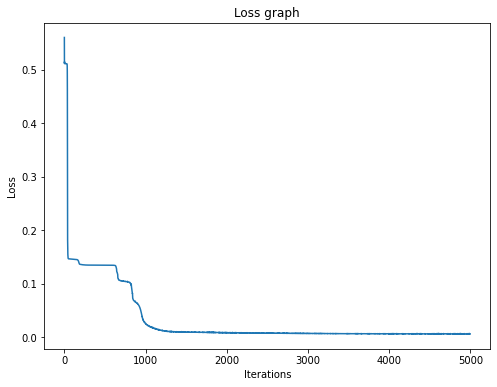

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

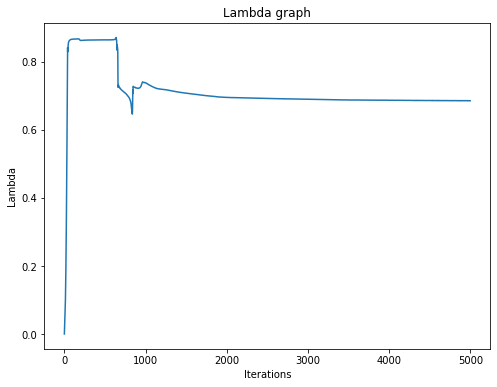

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [24]:
class PhysicsInformedNN3:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub, q):
        
        
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        self.q = q
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([2.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([1.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = (X - self.lb)/(self.ub - self.lb) 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.math.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
#         lambda_2 = self.lambda_2
        q = self.q 
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
#         u_tt = tf.gradients(u_t, t)[0]
        u_x = tf.gradients(u, x)[0]
#         u_xx = tf.gradients(u_x, x)[0]
#         f = q + lambda_1*u_x 
        f = q - lambda_1*(tf.math.sqrt(tf.math.square(u_x) + tf.math.square(u_t))) 
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, lambda_2))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
#                 lolz= self.sess.run(self.net_f(self.x_tf,self.t_tf) , tf_dict)
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
#                 print(lolz)
                start_time = time.time()
        
#         self.optimizer_Adam.minimize(self.loss)
        
        
#         self.optimizer.minimize(self.sess,
#                                 feed_dict = tf_dict,
#                                 fetches = [self.loss, self.lambda_1, self.lambda_2],
#                                 loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [25]:
model = PhysicsInformedNN3(X_u_train, u_train, layers1, lb1, ub1 , q_t)
model.train(10000)

Device mapping:

It: 0, Loss: 1.862e+00, Lambda_1: 2.001, Lambda_2: 1.000000, Time: 0.52
It: 10, Loss: 1.279e+00, Lambda_1: 2.009, Lambda_2: 1.000000, Time: 0.14
It: 20, Loss: 8.830e-01, Lambda_1: 2.018, Lambda_2: 1.000000, Time: 0.11
It: 30, Loss: 6.592e-01, Lambda_1: 2.029, Lambda_2: 1.000000, Time: 0.09
It: 40, Loss: 5.625e-01, Lambda_1: 2.040, Lambda_2: 1.000000, Time: 0.09
It: 50, Loss: 5.359e-01, Lambda_1: 2.053, Lambda_2: 1.000000, Time: 0.10
It: 60, Loss: 5.340e-01, Lambda_1: 2.066, Lambda_2: 1.000000, Time: 0.10
It: 70, Loss: 5.349e-01, Lambda_1: 2.081, Lambda_2: 1.000000, Time: 0.10
It: 80, Loss: 5.345e-01, Lambda_1: 2.096, Lambda_2: 1.000000, Time: 0.10
It: 90, Loss: 5.339e-01, Lambda_1: 2.111, Lambda_2: 1.000000, Time: 0.10
It: 100, Loss: 5.337e-01, Lambda_1: 2.127, Lambda_2: 1.000000, Time: 0.10
It: 110, Loss: 5.338e-01, Lambda_1: 2.143, Lambda_2: 1.000000, Time: 0.10
It: 120, Loss: 5.338e-01, Lambda_1: 2.159, Lambda_2: 1.000000, Time: 0.10
It: 130, Loss: 5.337e-01, Lambda

It: 1120, Loss: 2.065e-01, Lambda_1: 1.991, Lambda_2: 1.000000, Time: 0.11
It: 1130, Loss: 2.061e-01, Lambda_1: 1.977, Lambda_2: 1.000000, Time: 0.10
It: 1140, Loss: 2.056e-01, Lambda_1: 1.963, Lambda_2: 1.000000, Time: 0.10
It: 1150, Loss: 2.052e-01, Lambda_1: 1.949, Lambda_2: 1.000000, Time: 0.10
It: 1160, Loss: 2.047e-01, Lambda_1: 1.935, Lambda_2: 1.000000, Time: 0.10
It: 1170, Loss: 2.043e-01, Lambda_1: 1.921, Lambda_2: 1.000000, Time: 0.10
It: 1180, Loss: 2.038e-01, Lambda_1: 1.907, Lambda_2: 1.000000, Time: 0.10
It: 1190, Loss: 2.033e-01, Lambda_1: 1.893, Lambda_2: 1.000000, Time: 0.10
It: 1200, Loss: 2.029e-01, Lambda_1: 1.878, Lambda_2: 1.000000, Time: 0.11
It: 1210, Loss: 2.024e-01, Lambda_1: 1.864, Lambda_2: 1.000000, Time: 0.11
It: 1220, Loss: 2.019e-01, Lambda_1: 1.850, Lambda_2: 1.000000, Time: 0.11
It: 1230, Loss: 2.014e-01, Lambda_1: 1.836, Lambda_2: 1.000000, Time: 0.10
It: 1240, Loss: 2.009e-01, Lambda_1: 1.822, Lambda_2: 1.000000, Time: 0.10
It: 1250, Loss: 2.004e-01

It: 2230, Loss: 4.617e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.11
It: 2240, Loss: 4.546e-02, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.11
It: 2250, Loss: 4.479e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.11
It: 2260, Loss: 4.420e-02, Lambda_1: 0.874, Lambda_2: 1.000000, Time: 0.10
It: 2270, Loss: 4.354e-02, Lambda_1: 0.869, Lambda_2: 1.000000, Time: 0.10
It: 2280, Loss: 4.299e-02, Lambda_1: 0.865, Lambda_2: 1.000000, Time: 0.11
It: 2290, Loss: 4.248e-02, Lambda_1: 0.860, Lambda_2: 1.000000, Time: 0.11
It: 2300, Loss: 4.200e-02, Lambda_1: 0.855, Lambda_2: 1.000000, Time: 0.11
It: 2310, Loss: 4.157e-02, Lambda_1: 0.851, Lambda_2: 1.000000, Time: 0.11
It: 2320, Loss: 4.116e-02, Lambda_1: 0.846, Lambda_2: 1.000000, Time: 0.11
It: 2330, Loss: 4.077e-02, Lambda_1: 0.842, Lambda_2: 1.000000, Time: 0.11
It: 2340, Loss: 4.039e-02, Lambda_1: 0.838, Lambda_2: 1.000000, Time: 0.11
It: 2350, Loss: 4.002e-02, Lambda_1: 0.834, Lambda_2: 1.000000, Time: 0.11
It: 2360, Loss: 3.965e-02

It: 3330, Loss: 1.140e-02, Lambda_1: 0.677, Lambda_2: 1.000000, Time: 0.11
It: 3340, Loss: 1.132e-02, Lambda_1: 0.677, Lambda_2: 1.000000, Time: 0.11
It: 3350, Loss: 1.129e-02, Lambda_1: 0.677, Lambda_2: 1.000000, Time: 0.11
It: 3360, Loss: 1.118e-02, Lambda_1: 0.677, Lambda_2: 1.000000, Time: 0.11
It: 3370, Loss: 1.110e-02, Lambda_1: 0.677, Lambda_2: 1.000000, Time: 0.12
It: 3380, Loss: 1.103e-02, Lambda_1: 0.677, Lambda_2: 1.000000, Time: 0.12
It: 3390, Loss: 1.096e-02, Lambda_1: 0.677, Lambda_2: 1.000000, Time: 0.12
It: 3400, Loss: 1.090e-02, Lambda_1: 0.678, Lambda_2: 1.000000, Time: 0.12
It: 3410, Loss: 1.084e-02, Lambda_1: 0.678, Lambda_2: 1.000000, Time: 0.12
It: 3420, Loss: 1.078e-02, Lambda_1: 0.678, Lambda_2: 1.000000, Time: 0.11
It: 3430, Loss: 1.072e-02, Lambda_1: 0.678, Lambda_2: 1.000000, Time: 0.11
It: 3440, Loss: 1.067e-02, Lambda_1: 0.678, Lambda_2: 1.000000, Time: 0.11
It: 3450, Loss: 1.061e-02, Lambda_1: 0.678, Lambda_2: 1.000000, Time: 0.11
It: 3460, Loss: 1.056e-02

It: 4430, Loss: 8.131e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 4440, Loss: 8.120e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 4450, Loss: 8.110e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 4460, Loss: 8.100e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 4470, Loss: 8.089e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 4480, Loss: 8.079e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 4490, Loss: 8.069e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 4500, Loss: 8.059e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 4510, Loss: 8.049e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 4520, Loss: 8.039e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 4530, Loss: 8.029e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 4540, Loss: 8.020e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 4550, Loss: 8.125e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 4560, Loss: 8.030e-03

It: 5530, Loss: 7.390e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 5540, Loss: 7.376e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 5550, Loss: 7.386e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.14
It: 5560, Loss: 7.384e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 5570, Loss: 7.361e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 5580, Loss: 7.357e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 5590, Loss: 7.351e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 5600, Loss: 7.346e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 5610, Loss: 7.341e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.12
It: 5620, Loss: 7.335e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 5630, Loss: 7.330e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 5640, Loss: 7.325e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.13
It: 5650, Loss: 7.320e-03, Lambda_1: 0.687, Lambda_2: 1.000000, Time: 0.14
It: 5660, Loss: 7.315e-03

It: 6630, Loss: 6.882e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.14
It: 6640, Loss: 6.877e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.14
It: 6650, Loss: 6.873e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.14
It: 6660, Loss: 6.870e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.14
It: 6670, Loss: 6.868e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.16
It: 6680, Loss: 6.865e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 6690, Loss: 6.862e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.19
It: 6700, Loss: 6.859e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 6710, Loss: 6.874e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.20
It: 6720, Loss: 6.856e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.17
It: 6730, Loss: 6.859e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.16
It: 6740, Loss: 6.850e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.16
It: 6750, Loss: 6.845e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.15
It: 6760, Loss: 6.843e-03

It: 7730, Loss: 6.598e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.14
It: 7740, Loss: 6.593e-03, Lambda_1: 0.686, Lambda_2: 1.000000, Time: 0.14
It: 7750, Loss: 6.591e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.15
It: 7760, Loss: 6.588e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.14
It: 7770, Loss: 6.586e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.15
It: 7780, Loss: 6.583e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.14
It: 7790, Loss: 6.581e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.14
It: 7800, Loss: 6.579e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.13
It: 7810, Loss: 6.576e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.14
It: 7820, Loss: 6.575e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.15
It: 7830, Loss: 6.627e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.15
It: 7840, Loss: 6.589e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.15
It: 7850, Loss: 6.576e-03, Lambda_1: 0.685, Lambda_2: 1.000000, Time: 0.15
It: 7860, Loss: 6.569e-03

It: 8840, Loss: 6.357e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 8850, Loss: 6.358e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 8860, Loss: 6.478e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.16
It: 8870, Loss: 6.388e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 8880, Loss: 6.351e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 8890, Loss: 6.351e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 8900, Loss: 6.348e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.18
It: 8910, Loss: 6.344e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.21
It: 8920, Loss: 6.342e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 8930, Loss: 6.340e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 8940, Loss: 6.338e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 8950, Loss: 6.336e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.19
It: 8960, Loss: 6.335e-03, Lambda_1: 0.684, Lambda_2: 1.000000, Time: 0.20
It: 8970, Loss: 6.333e-03

It: 9940, Loss: 6.170e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 9950, Loss: 6.168e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 9960, Loss: 6.166e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 9970, Loss: 6.165e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16
It: 9980, Loss: 6.163e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.17
It: 9990, Loss: 6.161e-03, Lambda_1: 0.682, Lambda_2: 1.000000, Time: 0.16


In [30]:
from numpy.random import uniform, seed
from matplotlib.mlab import griddata
import matplotlib.pyplot as plt
import numpy as np

ImportError: cannot import name 'griddata'

In [32]:
x= x_y[:,0:1]
y= x_y[:,1:2]
z=u


xi = np.linspace(min(x), max(x), 30)
yi = np.linspace(min(y), max(y), 30)

X, Y = np.meshgrid(xi, yi)
Z = griddata(x, y, z, X, Y)

C:\Users\Omkar\anaconda3\envs\PINNtf1\lib\site-packages\scipy\interpolate\ndgriddata.py:198: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ndim == 1 and method in ('nearest', 'linear', 'cubic'):
C:\Users\Omkar\anaconda3\envs\PINNtf1\lib\site-packages\scipy\interpolate\ndgriddata.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif method == 'nearest':
C:\Users\Omkar\anaconda3\envs\PINNtf1\lib\site-packages\scipy\interpolate\ndgriddata.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif method == 'linear':
C:\Users\Omkar\anaconda3\envs\PINNtf1\lib\site-packages\scipy\interpolate\ndgriddata.py:221: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif m

ValueError: Unknown interpolation method array([[-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ],
       [-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]]) for 1 dimensional data